# Implementation of PID Controller

Propotional-Integral-Derivative (PID) is a versatile controller that uses the present error (Proportional), past error (Integral), and future error (Derivative) to calculate the appropriate control e.g. actuator command. Typically, PID controller is used with Single-In-Single-Out (SISO) system. 

MIMO system with PID is often complex due to the interactions between multiple inputs and outputs. That said, a few strategies can be used:
1. Model the MIMO System with State-Space or Transfer Function Model
   * You can derive the model from first principles or identify it using system identification techniques.
2. Analyze Coupling Effects
   * Understand how the inputs affect the outputs. 
   * This might involve analyzing the system's transfer function matrix.
3. Decouple the System
   * If the interactions between the inputs and outputs are significant:
        * Feedback Decoupling: Adjust the feedback paths to minimize interaction.
        * Feedforward Control: Use feedforward control strategies to handle known disturbances.
    * Use of State Feedback: Can sometimes simplify the control design.
4. Design Individual PID Controllers
    * Single Loop Design: Treat each input-output pair as a separate SISO system and design a PID controller for each pair.
        * Tuning Methods: Use methods like Ziegler-Nichols, Cohen-Coon, or software-based tools to tune each PID controller.
        * Simulation: Simulate each controller to assess performance.

__Note:__ Combine the Controllers: Once the individual PID controllers are designed, integrate them into the overall control system.
Consider Interactions: Ensure that the combination of controllers does not lead to instability or degraded performance due to cross-coupling.

__Source:__  
https://www.youtube.com/watch?v=wkfEZmsQqiA

__Note:__ 
* 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def plot_data(Hs, RPMs, target, show=True):
    # graphing
    n = len(Hs)
    fig, ax1 = plt.subplots()
    if show:
        ax2 = ax1.twinx()
        ax2.plot(range(n),RPMs,color='g')
        ax2.set_ylabel('RPM (Rounds per minute)')
        ax2.yaxis.label.set_color('green')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('height (m)')
    ax1.plot(range(n),Hs,color='black')
    ax1.axhline(target, color='r', linestyle='--')
    
    fig.tight_layout()
    plt.show()

In [4]:
class system:
    """This class represents a drone moving in 1D, subject to gravity and lift force
    """
    def __init__(self, mass, timestep):
        self.timestep = timestep
        self.timecurrent = 0
        self.g = -9.812  # ms^-2
        self.mass = mass # kg
        self.C = 1.3  # max lift coefficient for a symmetrical aerofoil
        self.density = 1.2 # kgm^-3
        self.blade_width = 0.005  # m :: rotor blade width
        self.blade_radius = 0.5 # m :: rotor blade radius
        self.blade_area = 2*self.blade_width*self.blade_radius  # m^2 :: rotor blade area
        self.H_prev = 0
        self.v_prev = 0
        
    def update(self, rpm):
        """ Update the speed of the drone based on the rotor speed v.
        
        F = mg + (1/2 * rho * C * A * v_rotor^2) = mv/dt
        where v_rotor: the speed of the blades at about 70% of the radius (This is only an approximation, 
                        as we should really integrate the lift over the length of the blade, to account 
                        for the tips moving faster than the root.
              v_rotor = circumference of blade path * Rounds per Second (i.e. RPM/60)

              To lift its own weight, v_rotor is when F=0.
        """
        # calculate rotor speed
        v_rotor = (2*np.pi*self.blade_radius*0.7*rpm/60)
        # calculate net force
        F = (self.mass*self.g) + (0.5*self.density*self.C*self.blade_area*(v_rotor**2))
        # calculate acceleration
        a = F/self.mass*self.timestep
        # calculate speed
        v_current = self.v_prev + a*self.timestep
        # calculate height
        H_current = max(self.H_prev + (v_current*self.timestep), 0)
        
        # record data
        self.H_prev = H_current
        self.v_prev = v_current
        self.timecurrent += self.timestep
        
        return H_current

# PID Controller
<img src="./img/PID_algorithms.png" alt="PID algorithms" style="width:800px"> 
 
## Key terms
* __Process Variable (PV)__: Any OUTPUT variables that we can measure and desire to control.
* __Controlled Variable (CV)__: PV that we desire to control to steady state.
* __Set-Point (SP) or Steady-state Value (SV)__: The desired value of CV. Meaning, Error (E) = SP-PV.
* __Manipulated Variable (MV)__: Any INPUT variable that we can control and directly affects OUTPUT.
* __Disturbance Variable (D)__: Any remaining INPUT variables that we have no control over but affects OUTPUT.

In [78]:
class PID:
    """This class implements PID controller
    """
    def __init__(self, target, timestep, start_position=0):
        self.measurement = 0
        self.timestep = timestep
        self.target = target # desired state (in this case, height)
        self.prev_error = self.target - start_position
        self.hist_error = []
        self.P = 0
        self.I = 0
        self.D = 0
        self.hist_P = []
        self.hist_I = []
        self.hist_D = []
        self.KP = 1  # Proportional gains (ratio): determines how fast the system responds
        self.KI = 0  # Integral gains (Repeats per unit time), same as 1/T_i: determines how fast the steady-state error is removed
        self.KD = 0  # Derivative gains (unit time): how far in the future you want to predict the rate of change
        
        self.MV_offset = 0  # offset to MV
        self.MV_max = 600  # Maximum allowable MV
        self.MV_min = 0  # Maximum allowable MV
        
        
    def saturate(self, MV):
        MV = min(self.MV_max, MV)
        MV = max(self.MV_min, MV)
        return MV
    
    
    def compute(self, measurement):
        # calculate error
        _error = self.target - measurement
        self.hist_error.append(_error)
        
        # calculate PID commands
        self.P = self.KP * _error
        self.I += (self.KI*_error*self.timestep)
        self.D = self.KD * (_error-self.prev_error)/self.timestep
        command = self.MV_offset+self.P+self.I+self.D
        self.hist_P.append(self.P)
        self.hist_I.append(self.I)
        self.hist_D.append(self.D)
        
        # apply saturation
        command = min(self.MV_max, command)
        command = max(self.MV_min, command)
        
        # record data
        self.measurement = measurement
        self.prev_error= _error
        
        return command

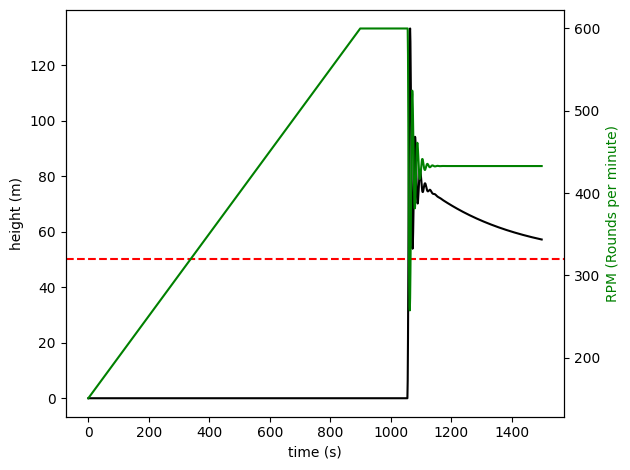

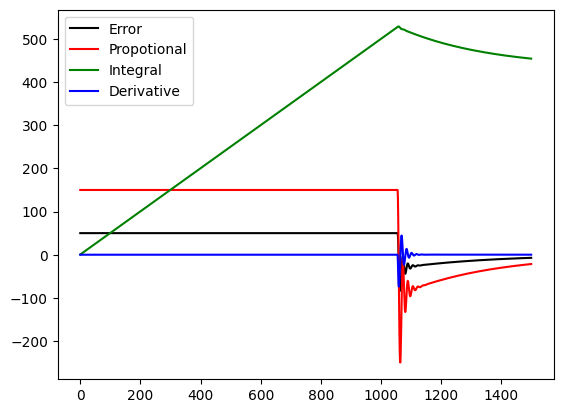

In [79]:
# instantiate
max_time = 1500 # seconds
timestep = 1 # seconds
pid = PID(target=50, timestep=timestep)
sys = system(mass=0.1, timestep=timestep)

# tune
## At the start, error = target-0 = 150m
pid.KP = 3
pid.KI = 0.01
pid.KD = 3

# compute
RPM = 0
RPMs = list()
Hs = list()
for i in range(int(max_time/timestep)):
    H = sys.update(RPM)
    RPM = pid.compute(H)
    RPMs.append(RPM)
    Hs.append(H)
    
plot_data(Hs, RPMs, 50)
plt.plot(range(len(Hs)), pid.hist_error, c='black', label="Error")
plt.plot(range(len(Hs)), pid.hist_P, c='red', label="Propotional")
plt.plot(range(len(Hs)), pid.hist_I, c='green', label="Integral")
plt.plot(range(len(Hs)), pid.hist_D, c='blue', label="Derivative")
plt.legend()

# Tuning PID controller

# Improvement
We can improve the oscillations by introducing:
1. Anti-windup gain/compensation @ Integral Controller
   > When we apply the saturator to our system (min-max MV value), errors can linger for a long time albeit intentional. However, this will cause the Integrator to have a very large values, leading to significant overshoot. The concept here is that **if the saturation occurs, stop integating error.**
   <img src="./img/antiwindup_scheme.png" alt="Anti-Windup Scheme" width="400"/>   
2. Derivative filtering @ Derivative Controller
3. Rate limiter

In [80]:
class PID_v2:
    """This class implements PID controller
    """
    def __init__(self, target, timestep, start_position=0):
        self.measurement = 0
        self.timestep = timestep
        self.P = 0
        self.I = 0
        self.D = 0
        self.hist_P = []
        self.hist_I = []
        self.hist_D = []
        self.KP = 1  # Proportional gains
        self.KI = 0  # Integral gains
        self.KD = 0  # Derivative gains
        self.Kaw = 0  # Anti-windup gains
        self.MV_offset = 0  # offset to manipulated variable value
        self.MV_max = 600  # Maximum allowable manipulated variable value
        self.MV_min = 0  # Maximum allowable manipulated variable value
        self.target = target # desired state (in this case, height)
        self.command_prev = 0
        self.command_prev_sat = 0
        self.prev_error = self.target - start_position
        self.hist_error = []
        
    def compute(self, measurement):
        # calculate error
        _error = self.target - measurement
        self.hist_error.append(_error)
        
        # calculate PID commands
        self.P = self.KP * _error
        self.I += (self.KI*_error*self.timestep) + self.Kaw*(self.command_prev_sat-self.command_prev)*self.timestep
        self.D = self.KD * (_error-self.prev_error)/self.timestep
        command = self.MV_offset+self.P+self.I+self.D
        self.hist_P.append(self.P)
        self.hist_I.append(self.I)
        self.hist_D.append(self.D)
        
        # apply saturation
        self.command_prev = command  # record data before saturation for anti-windup calc
        command = min(self.MV_max, command)
        command = max(self.MV_min, command)
        self.command_prev_sat = command  # record data after saturation for anti-windup calc
        
        # record data
        self.measurement = measurement
        self.prev_error= _error
        
        return command

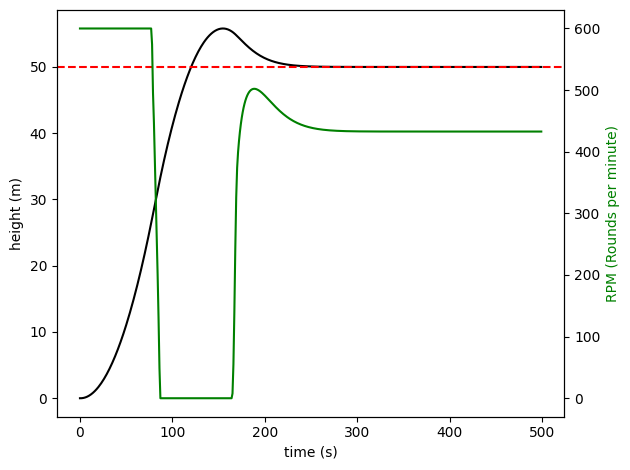

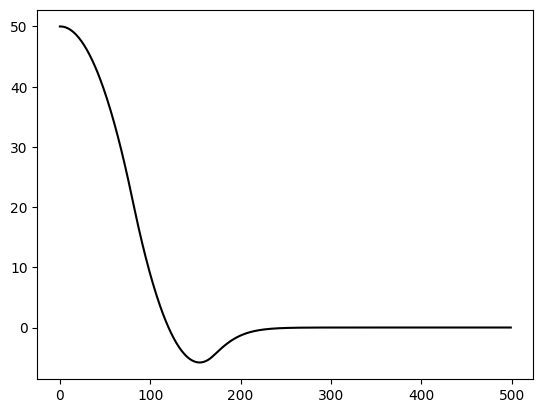

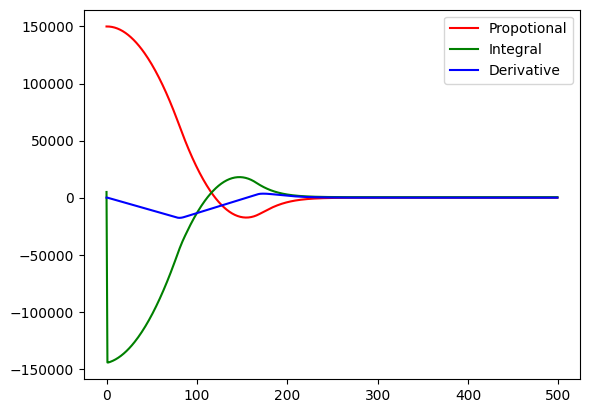

In [82]:
# instantiate
max_time = 50 # seconds
timestep = 0.1 # seconds
pid = PID_v2(target=50, timestep=timestep)
sys = system(mass=0.1, timestep=timestep)

# tune
## At the start, error = target-0 = 150m
pid.KP = 3000
pid.KI = 1000
pid.KD = 2500
pid.Kaw = 10

# compute
RPM = 0
RPMs = list()
Hs = list()
for i in range(int(max_time/timestep)):
    H = sys.update(RPM)
    RPM = pid.compute(H)
    RPMs.append(RPM)
    Hs.append(H)
    
plot_data(Hs, RPMs, 50, show=True)
plt.plot(range(len(Hs)), pid.hist_error, c='black', label="Error")
plt.show()
plt.plot(range(len(Hs)), pid.hist_P, c='red', label="Propotional")
plt.plot(range(len(Hs)), pid.hist_I, c='green', label="Integral")
plt.plot(range(len(Hs)), pid.hist_D, c='blue', label="Derivative")
plt.legend()